In [1]:
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import s3fs
import concurrent.futures
import matplotlib.pyplot as plt

In [2]:
s3 = s3fs.S3FileSystem(anon=True)

## Before WIT processing check

In [10]:
full_polygons = gpd.read_file("s3://dea-public-data-dev/projects/WIT/BWS_MDBA_ANAE_WIT_05_2022/shp_file/ANAEv3_WIT_clean19042022/ANAEv3_WIT_clean.shp")

In [11]:
full_polygons

,UID,ANAE_TYPE,Area_Ha,geometry
0,r1dtvqu5m,F4: Unspecified riparian zone or floodplain,3.972622,"POLYGON ((611266.353 -3895503.720, 611256.319 ..."
1,r1dtygfug,Pt2.1.2: Temporary tall emergent marsh,3.316279,"POLYGON ((617367.374 -3897620.931, 617370.374 ..."
2,r1dtyggsf,Etd1.2.1: Tide dominated saltmarsh,2.217581,"POLYGON ((617038.183 -3897457.937, 617042.095 ..."
3,r1dtyjqxg,Pt4.2: Temporary wetland,5.736414,"POLYGON ((614794.869 -3896524.926, 614794.833 ..."
4,r1dtyjxp1,Pt2.1.2: Temporary tall emergent marsh,4.490608,"POLYGON ((614794.869 -3896524.926, 614784.178 ..."
...,...,...,...,...
270648,r7hh7kxjv,Rt1.1: Temporary high energy upland stream,1.008318,"POLYGON ((1949229.310 -3119406.198, 1949232.82..."
270649,r7hh7m4fc,Rt1.1: Temporary high energy upland stream,2.508319,"POLYGON ((1948684.816 -3119059.552, 1948649.94..."
270650,r7hhdb24d,Rt1.1: Temporary high energy upland stream,3.858787,"POLYGON ((1946809.814 -3116801.769, 1946769.42..."
270651,r7hhdvgdj,Rt1.1: Temporary high energy upland stream,1.213341,"POLYGON ((1947536.645 -3113549.088, 1947530.54..."


In [16]:
full_polygons.crs

<Projected CRS: EPSG:3577>
Name: GDA94 / Australian Albers
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Australia - Australian Capital Territory; New South Wales; Northern Territory; Queensland; South Australia; Tasmania; Western Australia; Victoria.
- bounds: (112.85, -43.7, 153.69, -9.86)
Coordinate Operation:
- name: Australian Albers
- method: Albers Equal Area
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
# 1. check UID is unique
unique_id_column_name = "UID"
len(full_polygons[unique_id_column_name]) == len(set(full_polygons[unique_id_column_name]))

True

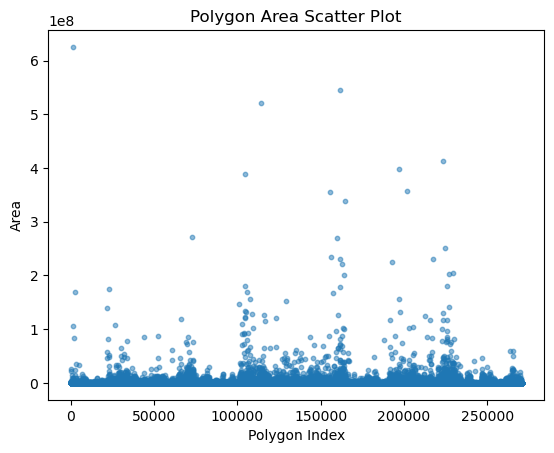

In [13]:
# 2. visualizate polygon size
# Extract the areas of the polygons

areas = full_polygons.geometry.area

# Create a scatter plot
plt.scatter(range(len(areas)), areas, s=10, alpha=0.5)

# Set the chart title and labels
plt.title("Polygon Area Scatter Plot")
plt.xlabel("Polygon Index")
plt.ylabel("Area")

# Display the scatter plot
plt.show()

In [14]:
# 3. check geometry overlay or not
# Create a spatial index for faster queries

full_polygons_sindex = full_polygons.sindex

import warnings

# Turn off all warning messages
warnings.filterwarnings("ignore")

# Create a list to store overlapping polygon rows
overlapping_rows = []

# Iterate over each polygon in the GeoDataFrame
for i, polygon in full_polygons.iterrows():
    # Create a bounding box around the polygon
    bbox = polygon.geometry.bounds

    # Use the spatial index to find potential overlaps
    potential_overlaps = list(full_polygons_sindex.intersection(bbox))

    # Check for actual overlaps with each potential overlap
    for j in potential_overlaps:
        if i != j:
            other_polygon = full_polygons.iloc[j]
            if polygon.geometry.intersects(other_polygon.geometry) and not polygon.geometry.touches(other_polygon.geometry):
                overlapping_rows.append(polygon)
                overlapping_rows.append(other_polygon)

# Remove duplicates (optional, if you want unique overlapping polygons)
overlapping_polygons = gpd.GeoDataFrame(overlapping_rows).drop_duplicates()

# Display the overlapping polygons
overlapping_polygons

,UID,ANAE_TYPE,Area_Ha,geometry
292,r1dvcwur6,Pt3.1.2: Clay pan,2.676933,"POLYGON ((628506.315 -3896722.357, 628505.256 ..."
1200,r1dyq4xpv,Lp1.1: Permanent lake,62537.129555,"POLYGON ((656421.092 -3876240.246, 656435.518 ..."
799,r1dwnvrtu,Lp1.1: Permanent lake,880.472964,"POLYGON ((615181.839 -3889420.830, 615189.004 ..."
825,r1dwpvmtd,Pt2.1.2: Temporary tall emergent marsh,126.659524,"POLYGON ((620421.277 -3891418.907, 620433.227 ..."
998,r1dy0jxgk,Pt2.1.2: Temporary tall emergent marsh,11.841199,"POLYGON ((623823.800 -3892205.812, 623590.140 ..."
...,...,...,...,...
230204,r6cc1962x,F1.8: Black box woodland riparian zone or floo...,8204.822213,"POLYGON ((1611470.499 -3283153.196, 1611446.76..."
248980,r6f6ez83m,Rp1.4: Permanent lowland stream,5.881922,"POLYGON ((1685939.425 -3272089.219, 1685958.91..."
248994,r6f6gcj02,F1.10: Coolibah woodland and forest riparian z...,915.876616,"POLYGON ((1684618.822 -3269441.210, 1684613.46..."
262754,r718t6vp3,Rt1.4: Temporary lowland stream,2.974657,"POLYGON ((1607429.409 -3146045.958, 1607728.74..."


In [9]:
# if we find overlap polygons, save them as shapefile to manually check
if len(overlapping_polygons) > 0:
    first_polygon_id = list(overlapping_polygons["UID"])[0]
    
    # just grab one polygon to make manually check easy
    single_overlap_polygon_gdf = full_polygons[full_polygons["UID"] == first_polygon_id]
    single_overlap_polygon_gdf.to_file("single_overlap_polygon.shp", driver='ESRI Shapefile')
    
    without_single_overlap_polygon_gdf = full_polygons[full_polygons["UID"] != first_polygon_id]
    without_single_overlap_polygon_gdf.to_file("single_overlap_polygons.shp", driver='ESRI Shapefile')

## After WIT processing check

In [ ]:
# load WIT result from output folder

files = s3.glob("s3://dea-public-data-dev/projects/WIT/BWS_MDBA_ANAE_WIT_09_04_2025/polygon_base_result/*.csv")
dfs = []

def load_csv(file):
    with s3.open(file, "rb") as f:
        df = pd.read_csv(f)
        return df

with concurrent.futures.ThreadPoolExecutor() as executor, \
        tqdm(total=len(files), desc="Loading CSVs") as pbar:

    futures = [executor.submit(load_csv, file) for file in files]
    for future in concurrent.futures.as_completed(futures):
        r = future.result()
        dfs.append(r)
        pbar.update(1)

df = pd.concat(dfs, ignore_index=True)

In [10]:
# only check the normalized columns

df['sum'] = df["water"] + df["wet"] + df["norm_bs"] + df["norm_npv"] + df["norm_pv"]

In [11]:
# 1. number of polygons in shape file matches number of polygons in shapefile
print("number of polygons in delivery CSV", len(set(df["feature_id"])))
print("number of polygons in shapefile", len(full_polygons))
print("we lost:", len(full_polygons) - len(set(df["feature_id"])), "polygons")

if len(set(df["feature_id"])) != len(full_polygons):
    # find the missing polygons from shapefile
    wit_result_missing_polygons = full_polygons[~full_polygons['UID'].isin(list(df['feature_id']))]
    wit_result_missing_polygons.to_file("wit_result_missing_polygons.shp", driver='ESRI Shapefile')

number of polygons in delivery CSV 36906
number of polygons in shapefile 38795
we lost: 1889 polygons


In [12]:
# 2. the number of timestampes of each polygons are make sense (e.g. no almost empty polygon base result)

# printout all polygon which size is less than 500 (less than 500 timestampes)
print("polygon with less than 500 timestampes:", len([e for e in dfs if len(e) < 500]))

polygon with less than 500 timestampes: 0


In [13]:
# 3. check the sum (wet + water + norm_pv + nrom_npv + norm_bs) values distribution information
df = df[df['pc_missing'] < 0.1] # drop all the low quality data (we keep them in WIT result for debug)
df = df.dropna(subset=['bs'])

print("timestampes great than 1.0001 / overall timestampes", len([df[df['sum'] > 1.00001]])/len(df))
print("timestampes less than < 0.99999 / overall timestamps", len([df[df['sum'] < 0.99999]])/len(df))

timestampes great than 1.0001 / overall timestampes 4.878769648451959e-08
timestampes less than < 0.99999 / overall timestamps 4.878769648451959e-08


In [17]:
import pandas as pd
df = pd.read_parquet("https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/projects/WIT/MDBA_ANAE_WIT_MH_LS_15_04_2025/timestamp_base_result/20240402/wit_ls8_10068fba-2370-4f85-836c-e8962b9218f4_20240402-003246-292791.pq")
df

,water,wet,bs,pv,npv,pc_missing
r45pp3xp9,0.000000,0.000000,0.525113,0.149676,0.307352,0.000000
r45q26ky5,0.000000,0.000000,0.481437,0.158524,0.342739,0.611578
r45znhd50,0.000000,0.000000,0.576564,0.049305,0.356646,0.050485
r45qzs7t5,0.000000,0.000000,0.426640,0.153733,0.403433,0.000000
r45w9nhbj,0.000498,0.009046,0.451722,0.147725,0.374385,0.036077
...,...,...,...,...,...,...
r1gtx45pm,NaN,NaN,NaN,NaN,NaN,1.000000
r1gts117q,NaN,NaN,NaN,NaN,NaN,1.000000
r1gte2zt6,NaN,NaN,NaN,NaN,NaN,1.000000
r1gte8cvu,NaN,NaN,NaN,NaN,NaN,1.000000


In [18]:
import requests
import zipfile
import io

url = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/projects/WIT/ANAEv3_WIT_result_22022024/ANAE_WIT_result_2024_02-part-0.zip"

# Stream the file
response = requests.get(url, stream=True)
response.raise_for_status()  # Ensure the request was successful

# Load the ZIP in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    # Get list of file names (excluding directories)
    file_list = [f for f in zip_file.namelist() if not f.endswith('/')]
    print(f"Number of files in the ZIP: {len(file_list)}")


Number of files in the ZIP: 27066


In [19]:
import requests
import zipfile
import io
import xml.etree.ElementTree as ET

# Base S3 "directory" URL (no index.html, so it lists files in XML format)
base_url = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com"
prefix = "projects/WIT/ANAEv3_WIT_result_22022024/"
listing_url = f"{base_url}/?prefix={prefix}"

# Step 1: List all zip files in the given S3 "directory"
response = requests.get(listing_url)
response.raise_for_status()

# Parse the XML response
root = ET.fromstring(response.content)
namespaces = {'s3': 'http://s3.amazonaws.com/doc/2006-03-01/'}
zip_urls = []

for contents in root.findall(".//s3:Contents", namespaces):
    key = contents.find("s3:Key", namespaces).text
    if key.endswith(".zip"):
        zip_urls.append(f"{base_url}/{key}")

# Step 2: Count files in each ZIP
for url in zip_urls:
    try:
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(r.content)) as zip_file:
            file_list = [f for f in zip_file.namelist() if not f.endswith('/')]
            print(f"{url.split('/')[-1]}: {len(file_list)} files")
    except Exception as e:
        print(f"Error processing {url}: {e}")


ANAE_WIT_result_2024_02-part-0.zip: 27066 files
ANAE_WIT_result_2024_02-part-1.zip: 27066 files
ANAE_WIT_result_2024_02-part-2.zip: 27066 files
ANAE_WIT_result_2024_02-part-3.zip: 27066 files
ANAE_WIT_result_2024_02-part-4.zip: 27066 files
ANAE_WIT_result_2024_02-part-5.zip: 27066 files
ANAE_WIT_result_2024_02-part-6.zip: 27066 files
ANAE_WIT_result_2024_02-part-7.zip: 27066 files
ANAE_WIT_result_2024_02-part-8.zip: 27066 files
ANAE_WIT_result_2024_02-part-9.zip: 27059 files


In [20]:
27066+27066+27066+27066+27066+27066+27066+27066+27066+27059

270653